In [49]:
using CSV, DataFrames
using PyCall
using CairoMakie

include("./src/cubes.jl")
include("./src/network.jl")

@pyimport powerlaw as powlaw

In [50]:
region = "japan"

"japan"

In [51]:
# Select 3 of the best cell sizes from parameter dependency analysis
if region == "romania"
    cell_sizes = [3.5,  4.5,  5.5];
    multiplier = [0.6, 1.0, 1.5]
elseif region == "california"
    cell_sizes = [1.0, 1.5, 2.0];
    multiplier = [0.8, 1.0, 2.2]
elseif region == "italy"
    cell_sizes = [4.0, 4.5, 5.0];
    multiplier = [0.4, 1.0, 2.5]
elseif region == "japan"
    cell_sizes = [2.5, 3.0, 3.5];
    multiplier = [0.3, 1.0, 3.0]
end;
# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);
# magnitude_threshold = 0.0

# Make path for results
mkpath("./results/$region")

    

"./results/japan"

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


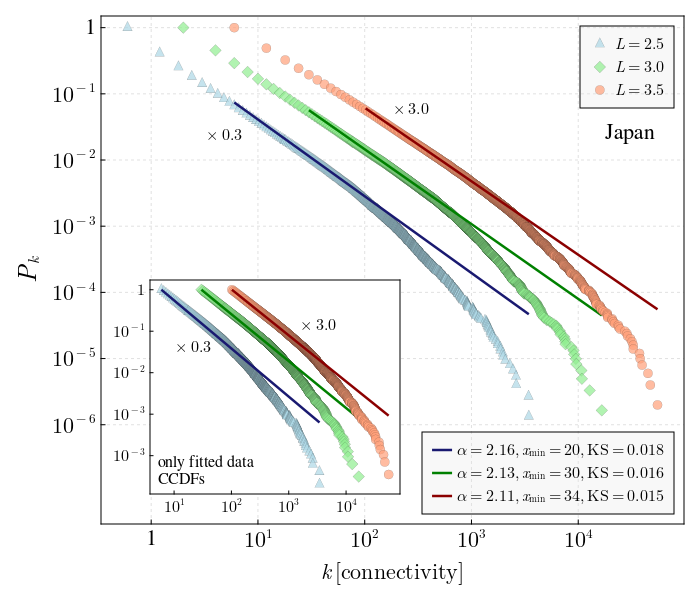

In [52]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)

########################################## TRUNCATED
ax2 = Axis(fig, bbox = BBox(150,400,106,320), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

sc1 = Array{Any,1}(undef,3)

for i in eachindex(cell_sizes)
    df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
    MG = create_network(df, df_cubes)
    degrees=[]
    for i in 1:nv(MG)
        push!(degrees, get_prop(MG, i, :degree))
    end

    # Powerlaw Fit
    fit = powlaw.Fit(degrees);
    alpha = round(fit.alpha, digits=2)
    xmin = Int(round(fit.xmin, digits=2))
    KS = round(fit.power_law.KS(data=degrees), digits=3)

    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    ########################################### ALL
    # CCDF of all data scattered 
    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)

    sc1[i] = scatter!(ax1, multiplier[i] .* x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    ln = lines!(ax1, multiplier[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label= L"\alpha=%$(alpha),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
    color=line_colors[i], linewidth=2.5, strokewidth=5) 


    ########################################### TRUNCATED
    # CCDF of truncated data (fitted), the plot, (re-normed)
    scatter!(ax2, multiplier[i] .* x_ccdf, y_ccdf,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data (re-normed)
    lines!(ax2, multiplier[i] .* x_powlaw, y_powlaw,
            color=line_colors[i], linewidth=2.5) 

end


text!(ax2, "only fitted data\nCCDFs", space = :relative, position = Point2f(0.03, 0.03))

translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)


# Top right, cell size legend
axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], position = :rt, bgcolor = (:grey90, 0.25), labelsize=16);
# Bottom left, results legend
axislegend(ax1, position = :rb, bgcolor = (:grey90, 0.25), labelsize=16);



if region == "romania"
    text!(ax1, "Romania", space = :relative, position = Point2f(0.84, 0.75), fontsize=22)
    ylims!(ax1, 10^(-5.5), 1.5)
    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3)],["1", L"10^{1}", L"10^{2}", L"10^{3}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(2), 10^(3)], [L"10^{2}", L"10^{3}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.32, 0.6), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.7), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.13, 0.5), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)
elseif region == "california"
    text!(ax1, "California", space = :relative, position = Point2f(0.825, 0.75), fontsize=22)
    ylims!(ax1, 10^(-7), 1.5)
    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(2), 10^(3),10^(4)], [L"10^{2}", L"10^{3}", L"10^{4}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.63, 0.75), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.15, 0.5), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.57, 0.75), fontsize=16)
elseif region == "italy"
    text!(ax1, "Italy", space = :relative, position = Point2f(0.87, 0.75), fontsize=22)
    ylims!(ax1, 10^(-6), 1.5)
    ax1.xticks = ([10^(0),10^(1),10^(2),10^(3),10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(1), 10^(2), 10^(3),10^(4)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.17, 0.75), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.52, 0.75), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.12, 0.65), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)
elseif region == "japan"
    text!(ax1, "Japan", space = :relative, position = Point2f(0.865, 0.75), fontsize=22)
    ylims!(ax1, 10^(-7.5), 1.5)
    ax1.xticks = ([10^(0), 10^(1), 10^(2), 10^(3), 10^(4)],["1", L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}"])
    ax1.yticks = ([10^(-6), 10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-6}", L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(1), 10^(2), 10^(3), 10^(4), 10^(5)], [L"10^{1}", L"10^{2}", L"10^{3}", L"10^{4}", L"10^{5}"])
    ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    text!(ax1, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.18, 0.75), fontsize=16)
    text!(ax1, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.5, 0.8), fontsize=16)
    
    text!(ax2, L"\times %$(multiplier[1])", space = :relative, position = Point2f(0.1, 0.65), fontsize=16)
    text!(ax2, L"\times %$(multiplier[3])", space = :relative, position = Point2f(0.6, 0.75), fontsize=16)
end




# Save plot
save( "./results/$region/$(region)_best_fits_all_data.png", fig, px_per_unit=7)
save( "./results/$region/$(region)_best_fits_all_data.pdf", fig)
fig


In [54]:
# set_theme!(Theme(fonts=(; regular="CMU Serif Bold")))
# fig1 = Figure(resolution = (600, 500), font= "CMU Serif") 
# ax1 = Axis(fig1[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
#     xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
#     xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

# markers=[:utriangle, :diamond, :circle]
# colors=[:lightblue, :lightgreen, :lightsalmon]
# line_colors=[:midnightblue, :green, :darkred]

# sc1 = Array{Any,1}(undef,3)

# for i in eachindex(cell_sizes)
#     df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
#     MG = create_network(df, df_cubes)
#     degrees=[]
#     for i in 1:nv(MG)
#         push!(degrees, get_prop(MG, i, :degree))
#     end

#     # Powerlaw Fit
#     fit = powlaw.Fit(degrees);
#     alpha = round(fit.alpha, digits=2)
#     xmin = Int(round(fit.xmin, digits=2))
#     KS = round(fit.power_law.KS(data=degrees), digits=3)

#     # CCDF of truncated data (fitted), x and y values
#     x_ccdf, y_ccdf = fit.ccdf()

#     # The fit (from theoretical power_law)
#     fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
#     x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

#     ########################################### ALL
#     # CCDF of all data scattered 
#     x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)


#     sc1[i] = scatter!(ax1, multiplier[i] .* x_ccdf_original_data, y_ccdf_original_data,
#         color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

#     # Fit through truncated data
#     # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
#     ln = lines!(ax1, multiplier[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label= L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)",
#     color=line_colors[i], linewidth=2.5, strokewidth=5) 


# end

# # Top right, cell size legend
# axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], [L"\text{cell\,size}=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], position = :rt, bgcolor = (:grey90, 0.25));
# # Bottom left, results legend
# axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25));


# # # Save both plots
# save( "./results/$region/$(region)_minmag_$(magnitude_threshold)_best_fits_all_data.png", fig1, px_per_unit=5)
# fig1


In [55]:
# set_theme!(Theme(fonts=(; regular="CMU Serif Bold")))

# fig2 = Figure(resolution = (600, 500), font= "CMU Serif") 
# ax2 = Axis(fig2[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
#     xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
#     xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10)

# markers=[:utriangle, :diamond, :circle]
# colors=[:lightblue, :lightgreen, :lightsalmon]
# line_colors=[:midnightblue, :green, :darkred]

# sc1 = Array{Any,1}(undef,3)
# sc2 = Array{Any,1}(undef,3)

# for i in eachindex(cell_sizes)
#     df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
#     MG = create_network(df, df_cubes)
#     degrees=[]
#     for i in 1:nv(MG)
#         push!(degrees, get_prop(MG, i, :degree))
#     end

#     # Powerlaw Fit
#     fit = powlaw.Fit(degrees);
#     alpha = round(fit.alpha, digits=2)
#     xmin = Int(round(fit.xmin, digits=2))
#     KS = round(fit.power_law.KS(data=degrees), digits=3)

#     # CCDF of truncated data (fitted), x and y values
#     x_ccdf, y_ccdf = fit.ccdf()

#     # The fit (from theoretical power_law)
#     fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
#     x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()


#     ########################################### TRUNCATED
#     # CCDF of truncated data (fitted), the plot, (re-normed)
#     sc2[i] = scatter!(ax2, multiplier_just_fits[i] .* x_ccdf, y_ccdf,
#         color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

#     # Fit through truncated data (re-normed)
#     ln = lines!(ax2, multiplier_just_fits[i] .* x_powlaw, y_powlaw, label= L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)",
#             color=line_colors[i], linewidth=2.5) 

# end

# # Top right, cell size legend
# axislegend(ax2, [sc2[i] for i in eachindex(cell_sizes)],  [L"\text{cell\,size}=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], position = :rt, bgcolor = (:grey90, 0.25));

# # Bottom left, results legend
# # axislegend(ax2, position = :lb, bgcolor = (:grey90, 0.25));

# # Save both plots
# # save("./results/$region/$(region)_minmag_$(magnitude_threshold)_best_fits.png", fig2, px_per_unit=5)
# fig2


In [58]:
# region = "romania"
# cell_size = 5.0

# # Read data
# path = "./data/"
# filepath = path * region * ".csv"
# df = CSV.read(filepath, DataFrame);
# magnitude_threshold = 0.0

# # Make path for results
# mkpath("./results/$region")

# df, df_cubes = region_cube_split(df,cell_size=cell_size)
# MG = create_network(df, df_cubes)
# degrees=[]
# for i in 1:nv(MG)
#     push!(degrees, get_prop(MG, i, :degree))
# end

# # Powerlaw Fit
# fit = powlaw.Fit(degrees);
# alpha = round(fit.alpha, digits=2)
# xmin = Int(round(fit.xmin, digits=2))
# KS = round(fit.power_law.KS(data=degrees), digits=3)

# # CCDF of truncated data (fitted), x and y values
# x_ccdf, y_ccdf = fit.ccdf()

# # The fit (from theoretical power_law)
# fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
# x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()


# set_theme!(Theme(fonts=(; regular="CMU Serif Bold")))

# ########################################### ALL
# # CCDF of all data scattered 
# fig1 = Figure(resolution = (600, 500), font= "CMU Serif") 
# ax1 = Axis(fig1[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
#     xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
#     xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xtickformat="{:.1f}")

# x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)


# sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
#     color=(:midnightblue, 0.2), strokewidth=0.2, marker=:circle, markersize=13)

# # Fit through truncated data
# # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
# ln1 = lines!(ax1, x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw,
#     color=:red, linewidth=2.5) 

# axislegend(ax1, [sc1], [L"\text{cell\,size}=%$(cell_size)"], position = :rt, bgcolor = (:grey90, 0.25));
# axislegend(ax1, [ln1], [L"\alpha=%$(alpha),\, x_{min}=%$(xmin),\, KS=%$(KS)"], position = :lb, bgcolor = (:grey90, 0.25));

# fig1